# Star Wars Exploration
## Part B - An analysis of the gender situation in Star Wars​



In [1]:
# Import
import os
import json
import glob
import statistics
import community
import numpy as np
import pandas as pd
import nxviz as nxv
import networkx as nx  
import seaborn as sns
from scipy.stats import wilcoxon
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt

## 1. Data Load
### 1.1 Collect Files

In [2]:
DATA_PATH = './data'
FILES = dict()
for file_name in os.listdir(DATA_PATH):
    if file_name.startswith('gender_mapping'):
        continue
    full_file_path = os.path.join(DATA_PATH, file_name)
    FILES[os.path.splitext(file_name)[0]] = full_file_path

for k, v in FILES.items():
    print(k, '->', v)

starwars-episode-5-interactions -> ./data/starwars-episode-5-interactions.json
starwars-episode-3-interactions -> ./data/starwars-episode-3-interactions.json
starwars-episode-1-mentions -> ./data/starwars-episode-1-mentions.json
starwars-episode-4-mentions -> ./data/starwars-episode-4-mentions.json
starwars-full-interactions-allCharacters-merged -> ./data/starwars-full-interactions-allCharacters-merged.json
starwars-episode-6-mentions -> ./data/starwars-episode-6-mentions.json
starwars-episode-4-interactions -> ./data/starwars-episode-4-interactions.json
starwars-episode-3-mentions -> ./data/starwars-episode-3-mentions.json
starwars-episode-2-interactions -> ./data/starwars-episode-2-interactions.json
starwars-episode-7-interactions -> ./data/starwars-episode-7-interactions.json
starwars-episode-1-interactions-allCharacters -> ./data/starwars-episode-1-interactions-allCharacters.json
starwars-episode-3-interactions-allCharacters -> ./data/starwars-episode-3-interactions-allCharacters.j

In [3]:
# grab only the newest gender mapping
list_of_mappings = glob.glob(f'{DATA_PATH}/gender_mapping_*.json')
newest_mapping = sorted(list_of_mappings)[-1]
FILES['gender_mapping'] = newest_mapping

### 1.2 Load files

In [4]:
DATA = dict()

for k, v in FILES.items():
    with open(v) as f:
        DATA[k] = json.load(f)

# 2 Build Networks per Episode


In [5]:
def make_graph(nodes, edges):
    G = nx.Graph()
    for node in nodes:
        node['gender'] = find_name_in_node_mappings(gender_mappings['nodes'], node['name'])
        G.add_node(node['name'], **dict(zip(node.keys(),node.values())))
    for edge in edges:
        G.add_edge(nodes[edge['source']]['name'], nodes[edge['target']]['name'], **dict(zip(edge.keys(),edge.values())))
    return G

def find_name_in_node_mappings(mappings, name):
    gender = None
    for mapping in mappings:
        if mapping['name'] == name:
            gender = mapping['gender']
    if gender is None:
        raise KeyError(f'Did not find name "{name}"')
    else:
        return gender

gender_mappings = DATA['gender_mapping']

## 2.1 Load networks of mentions

In [6]:
episode_mentions = list(filter(lambda key: 'mention' in key and not 'full' in key, DATA.keys()))

In [7]:
MENTION_NETWORKS = dict()

for episode in episode_mentions:
    MENTION_NETWORKS[episode.replace('starwars-', '').replace('-interactions-allCharacters', '')] = make_graph(DATA[episode]['nodes'], DATA[episode]['links'])

## 2.2 Load networks of interactions

We are considering the allCharacters network to also have interactions between R2-D2 and Chewbacca.

In [8]:
episode_interactions = list(filter(lambda key: 'interactions-allCharacters' in key and not 'full' in key, DATA.keys()))

In [9]:
INTERACTION_NETWORKS = dict()

for episode in episode_interactions:
    INTERACTION_NETWORKS[episode.replace('starwars-', '').replace('-interactions-allCharacters', '')] = make_graph(DATA[episode]['nodes'], DATA[episode]['links'])

# 3 Analysis

The episodes in the analysis will be covered in order of release and not numbering.

In [10]:
colors = {'Male': 'tab:green', 'Female': 'tab:purple'}

## 3.1 Gender composition of a community​

We will have a look at each episode and each community of the episodes in order to understand how the communities are composed regarding the gender. 
The episodes can then be compared by calculating a purity of each community and then comparing the sum of the ratios.

In [11]:
def calculate_communities(network):
    communities = community.best_partition(network, random_state=42)
    for community_no in range(max(communities.values())):
        partition = [node for node, comm in communities.items() if comm == community_no]

        yield network.subgraph(partition), community_no+1

def plot_community(community_network, info):
    pos = nx.spring_layout(community_network, seed=42)
    edge_weights = list()
    for (_, _, d) in community_network.edges(data=True):
        edge_weights.append(d['value'])
    edge_widths = (edge_weights / np.quantile(edge_weights, 0.85)).tolist()
    fig, ax = plt.subplots(figsize=(15,10))
    genders = list(nx.get_node_attributes(community_network, 'gender').values())
    female_percentage = (genders.count('Female') / len(genders))*100
    nx.draw(community_network, pos, with_labels=True, width=edge_widths, node_color=list(map(lambda x: colors[x], genders)))
    ax.set_title(f'Community: {info}\nFemale percentage: {female_percentage:.2f}%')
    return female_percentage

FEMALE_PERCENTAGE = dict()
EPISODES = list()


### 3.1.1 Episode IV: A New Hope (1977)

Average Female Percentage: 16.20%


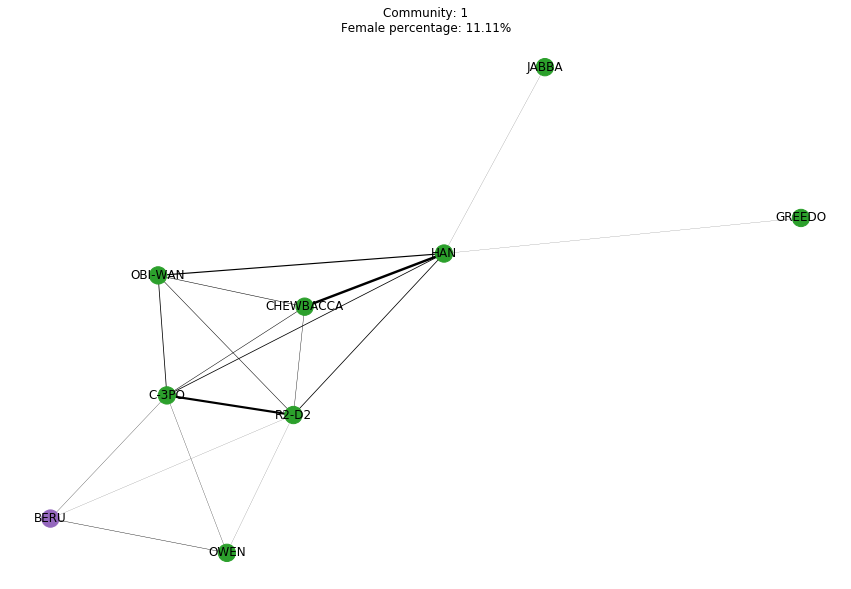

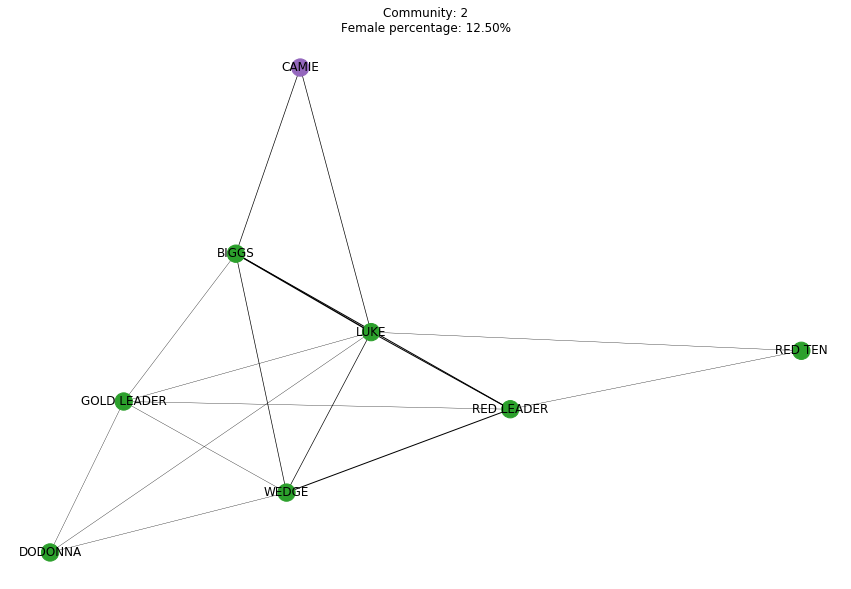

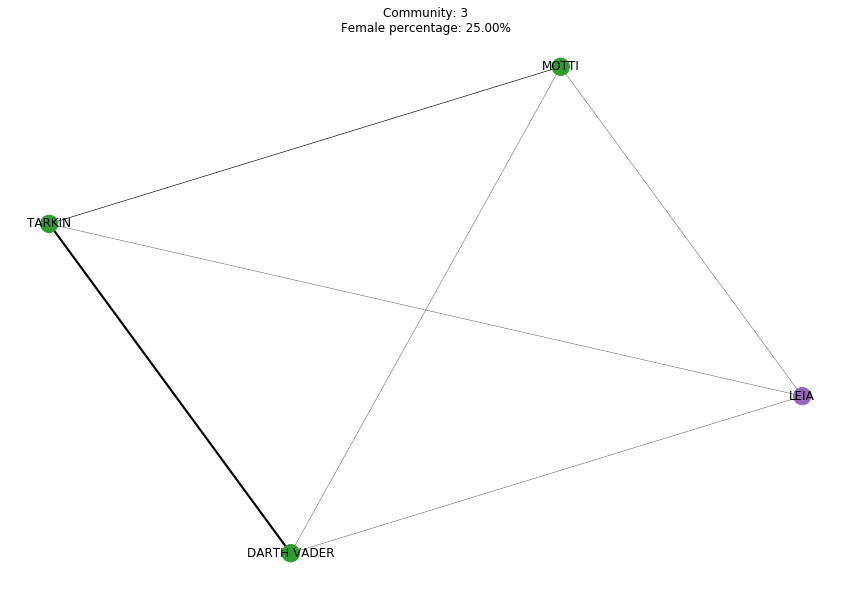

In [12]:
EPISODE = 'episode-4'
EPISODES.append(EPISODE)
interaction_network = INTERACTION_NETWORKS[EPISODE]
community_percentages = list()
for comm, no in calculate_communities(interaction_network):
    female_percentage = plot_community(comm, no)
    community_percentages.append(female_percentage)
print(f'Average Female Percentage: {np.mean(community_percentages):.2f}%')

FEMALE_PERCENTAGE[EPISODE] = community_percentages

### 3.1.2 Episode V: The Empire Strikes Back (1980)

Average Female Percentage: 5.56%


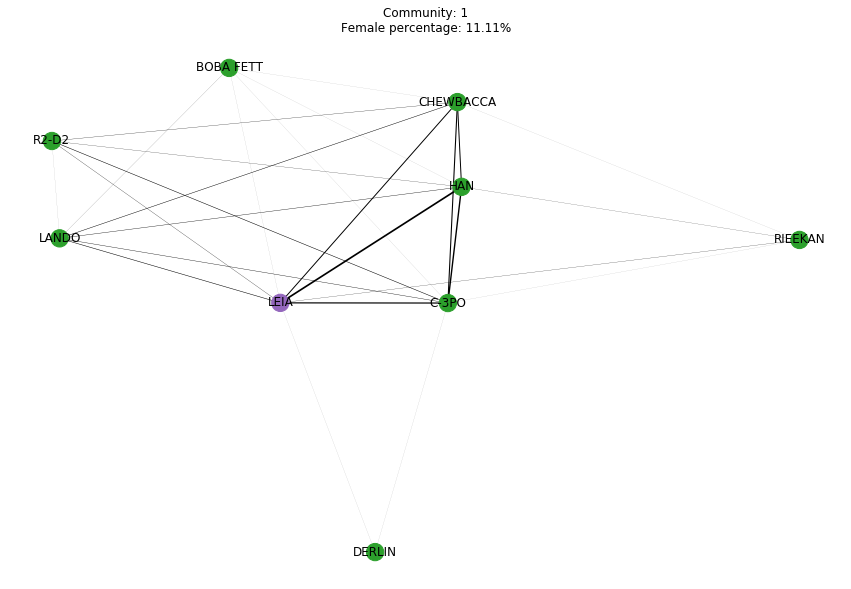

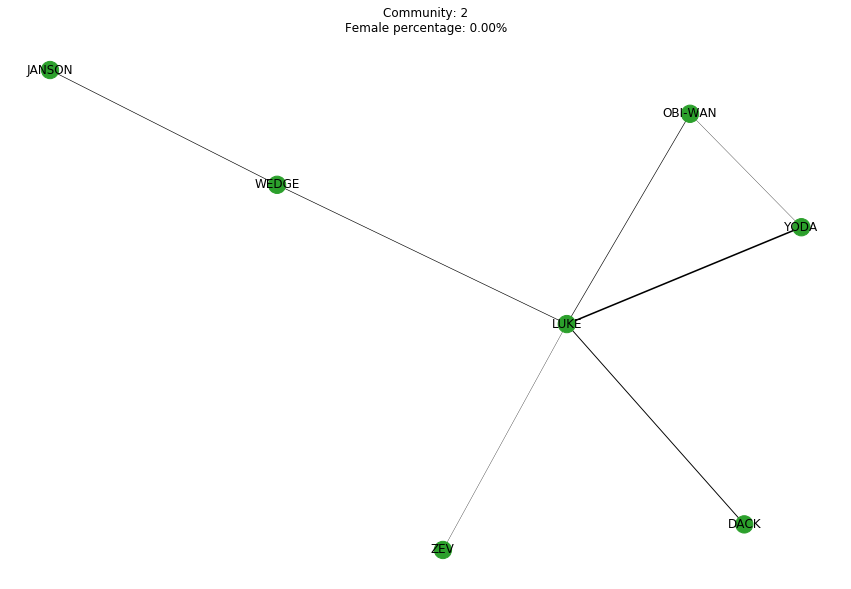

In [13]:
EPISODE = 'episode-5'
EPISODES.append(EPISODE)
interaction_network = INTERACTION_NETWORKS[EPISODE]
community_percentages = list()
for comm, no in calculate_communities(interaction_network):
    female_percentage = plot_community(comm, no)
    community_percentages.append(female_percentage)
print(f'Average Female Percentage: {np.mean(community_percentages):.2f}%')
FEMALE_PERCENTAGE[EPISODE] = community_percentages

### 3.1.3 Episode VI: The Return of the Jedi (1983)

Average Female Percentage: 12.50%


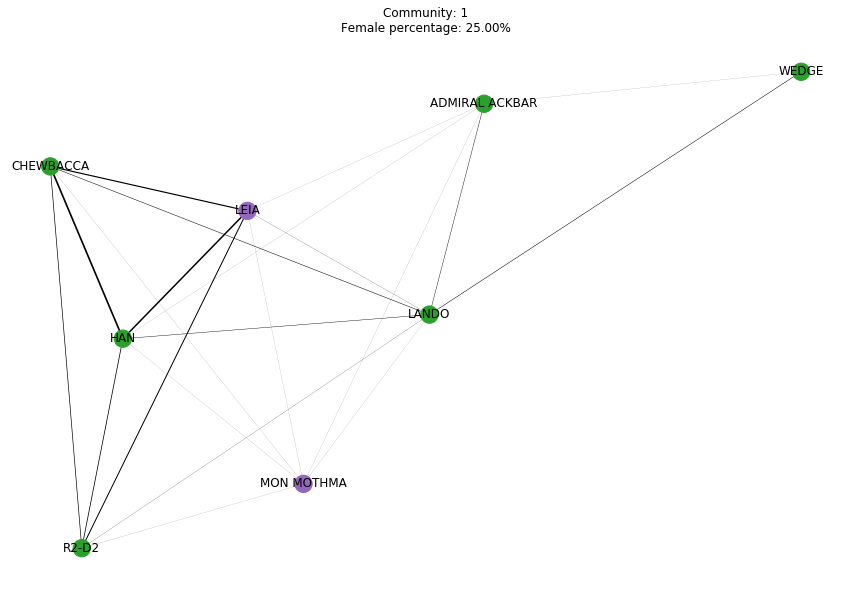

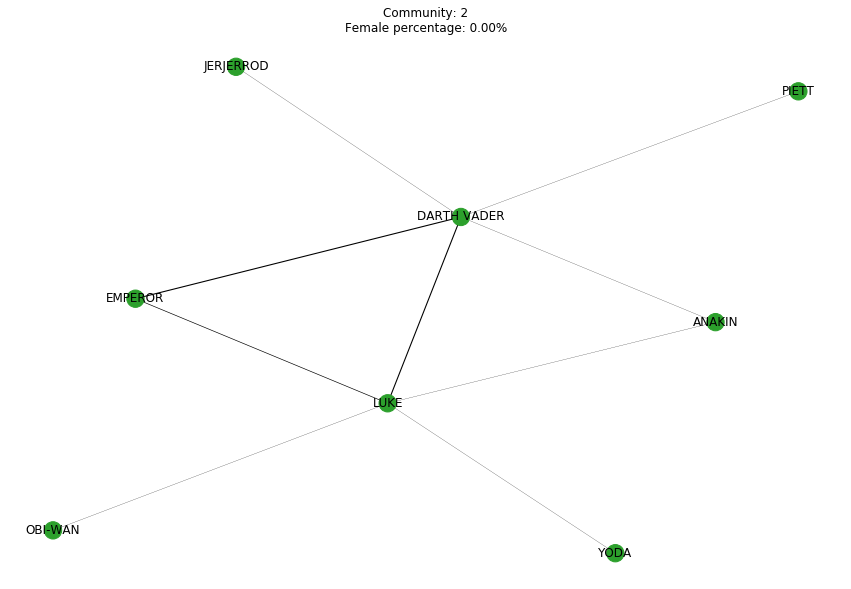

In [14]:
EPISODE = 'episode-6'
EPISODES.append(EPISODE)
interaction_network = INTERACTION_NETWORKS[EPISODE]
community_percentages = list()
for comm, no in calculate_communities(interaction_network):
    female_percentage = plot_community(comm, no)
    community_percentages.append(female_percentage)
print(f'Average Female Percentage: {np.mean(community_percentages):.2f}%')
FEMALE_PERCENTAGE[EPISODE] = community_percentages

### 3.1.4 Episode I: The Phantom Menace (1999)


Average Female Percentage: 16.49%


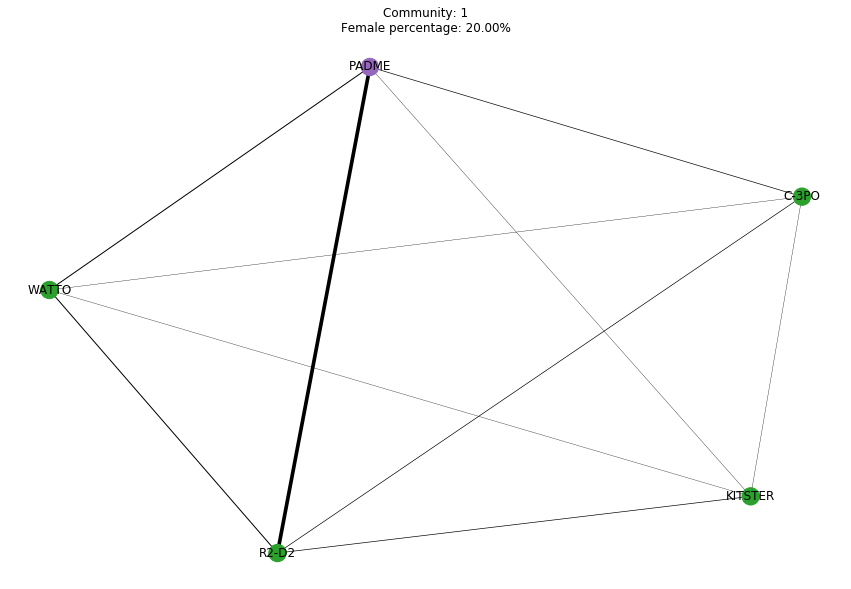

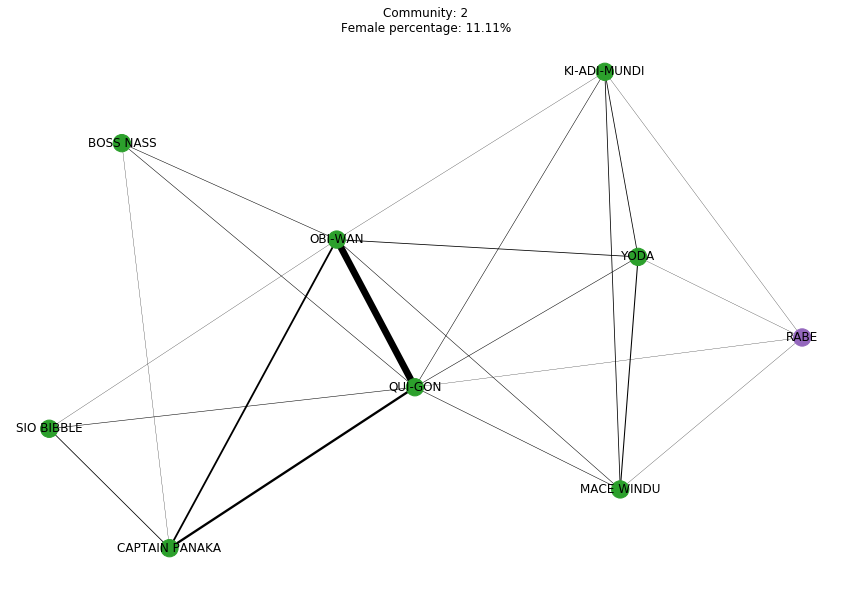

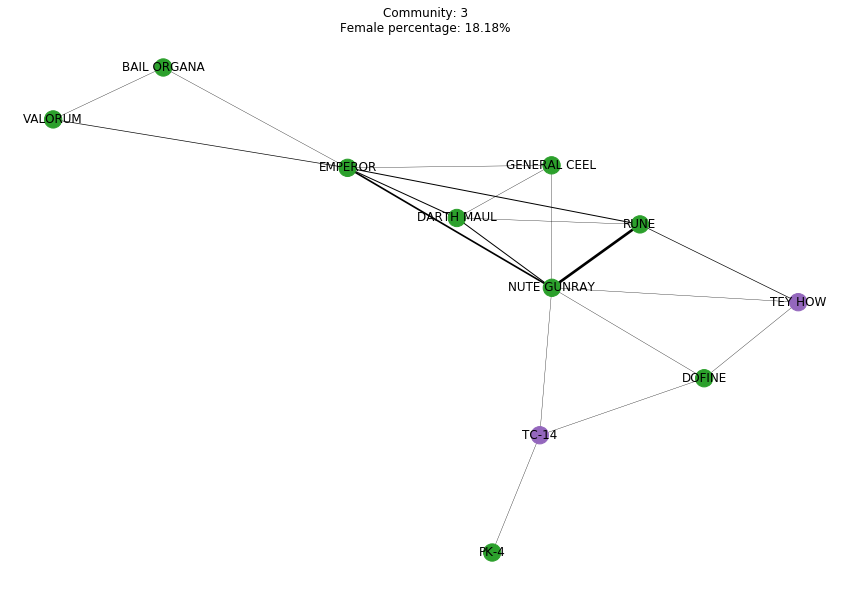

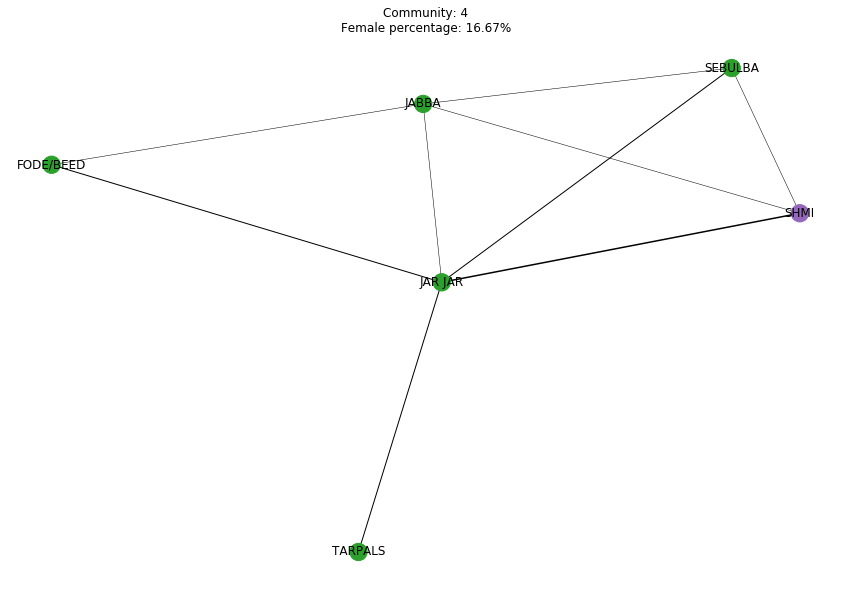

In [15]:
EPISODE = 'episode-1'
EPISODES.append(EPISODE)
interaction_network = INTERACTION_NETWORKS[EPISODE]

community_percentages = list()
for comm, no in calculate_communities(interaction_network):
    female_percentage = plot_community(comm, no)
    community_percentages.append(female_percentage)
    
print(f'Average Female Percentage: {np.mean(community_percentages):.2f}%')
FEMALE_PERCENTAGE[EPISODE] = community_percentages

### 3.1.5 Episode II: Attack of the Clones (2002)

Average Female Percentage: 17.86%


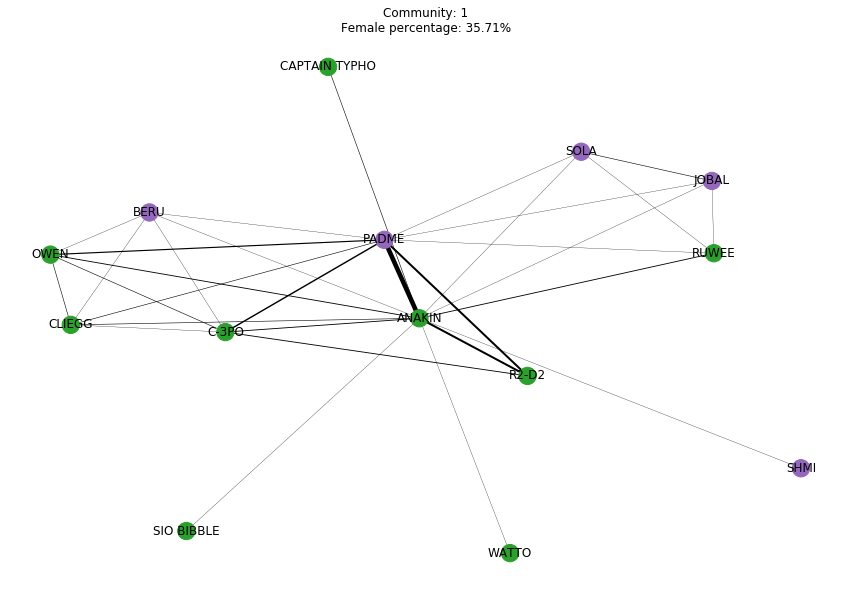

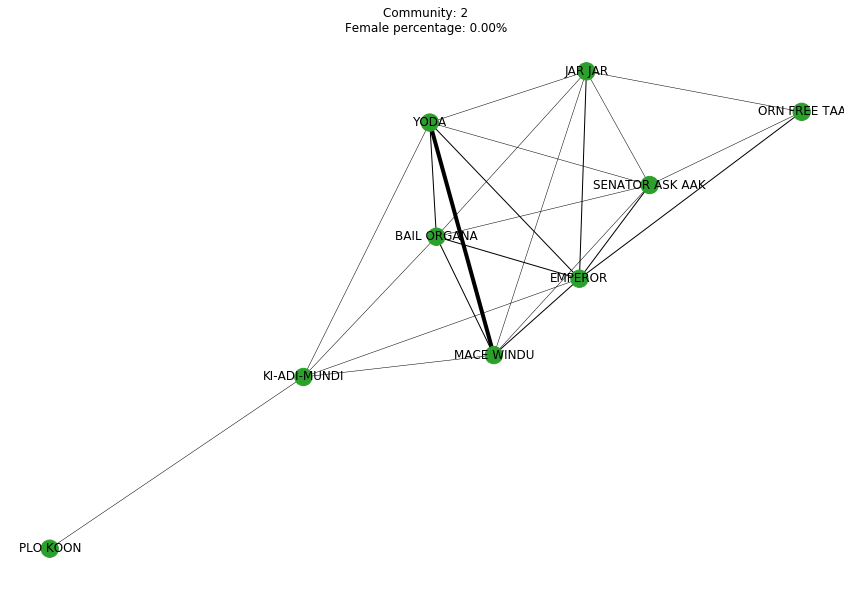

In [16]:
EPISODE = 'episode-2'
EPISODES.append(EPISODE)
interaction_network = INTERACTION_NETWORKS[EPISODE]
community_percentages = list()
for comm, no in calculate_communities(interaction_network):
    female_percentage = plot_community(comm, no)
    community_percentages.append(female_percentage)
print(f'Average Female Percentage: {np.mean(community_percentages):.2f}%')
FEMALE_PERCENTAGE[EPISODE] = community_percentages

### 3.1.6 Episode III: Revenge of the Sith (2005)

Average Female Percentage: 10.00%


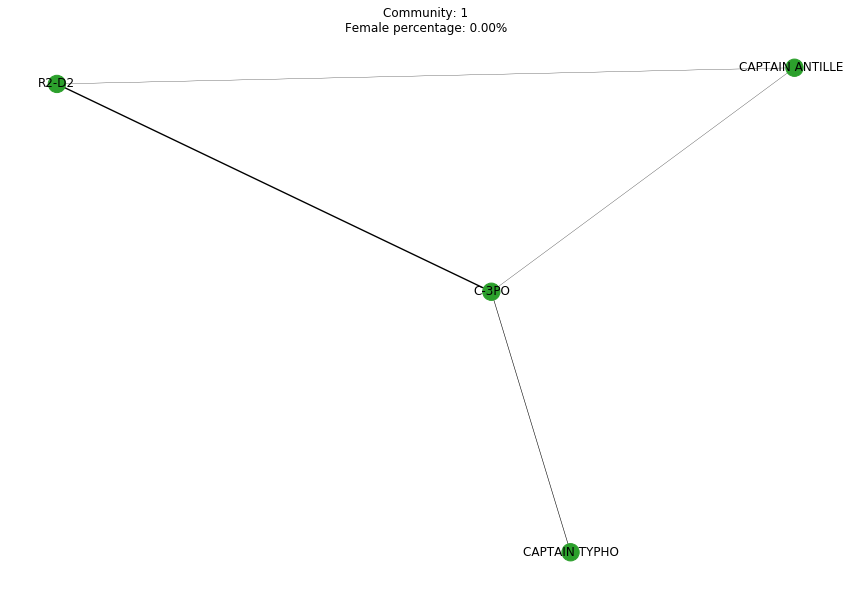

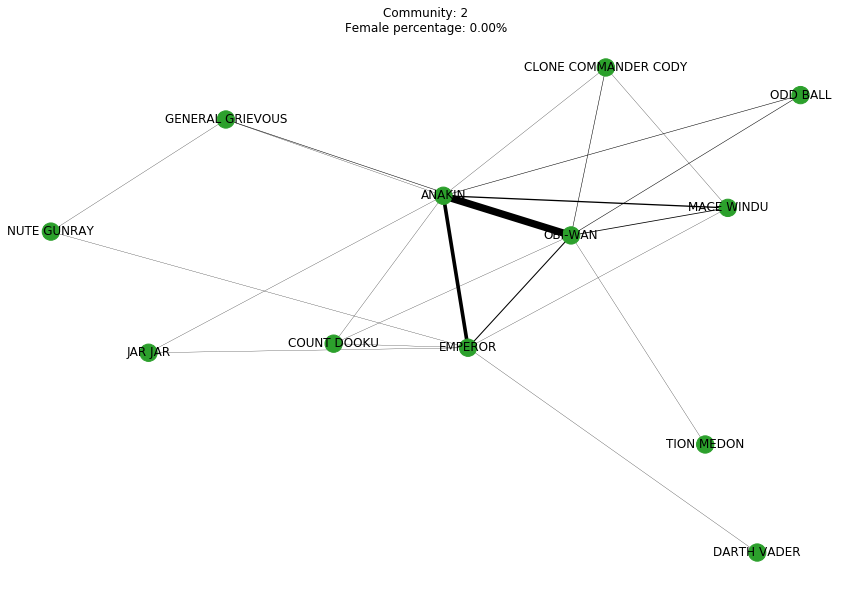

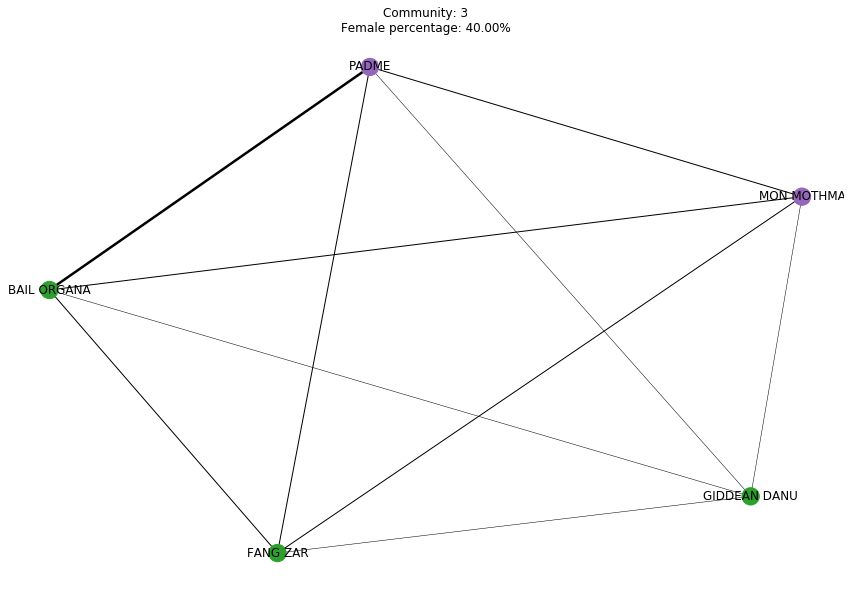

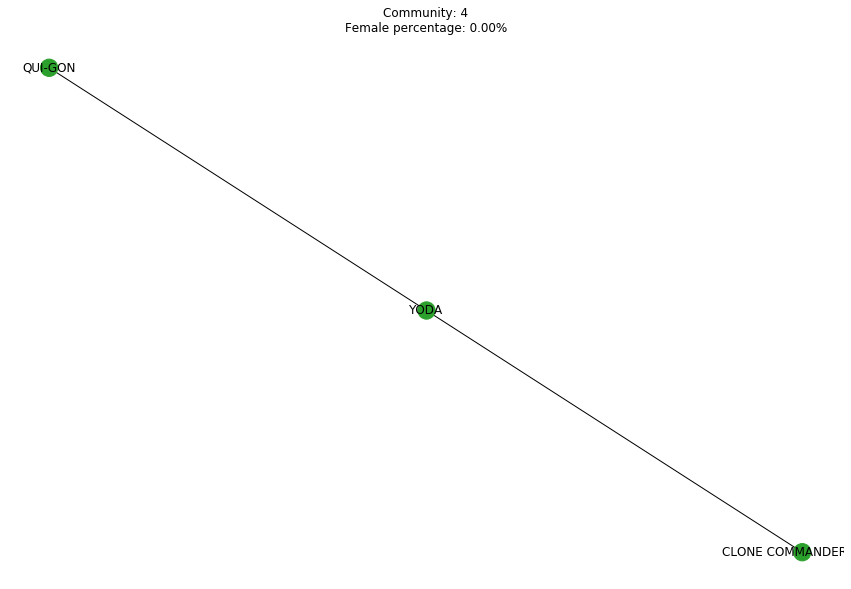

In [17]:
EPISODE = 'episode-3'
EPISODES.append(EPISODE)
interaction_network = INTERACTION_NETWORKS[EPISODE]
community_percentages = list()
for comm, no in calculate_communities(interaction_network):
    female_percentage = plot_community(comm, no)
    community_percentages.append(female_percentage)
print(f'Average Female Percentage: {np.mean(community_percentages):.2f}%')
FEMALE_PERCENTAGE[EPISODE] = community_percentages

### 3.1.7 Episode VII: The Force Awakens (2015)

Average Female Percentage: 19.76%


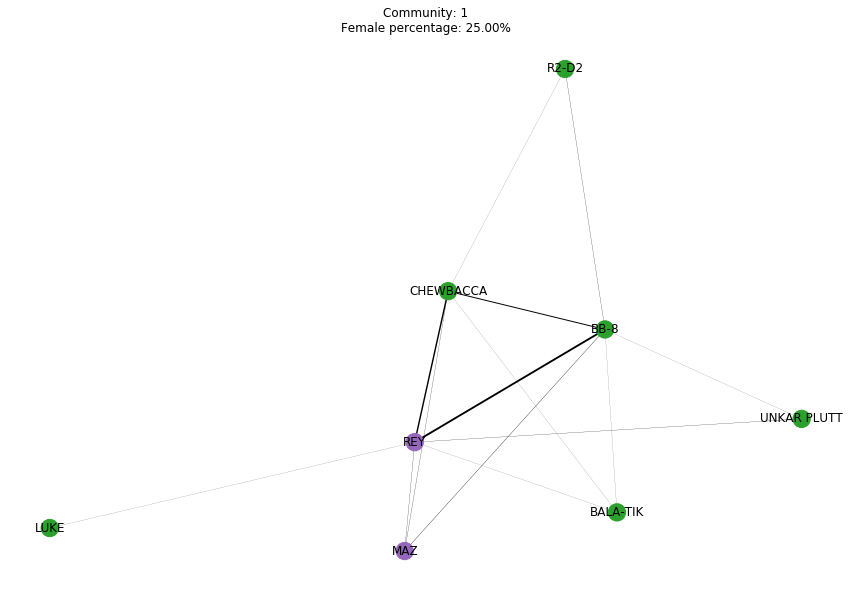

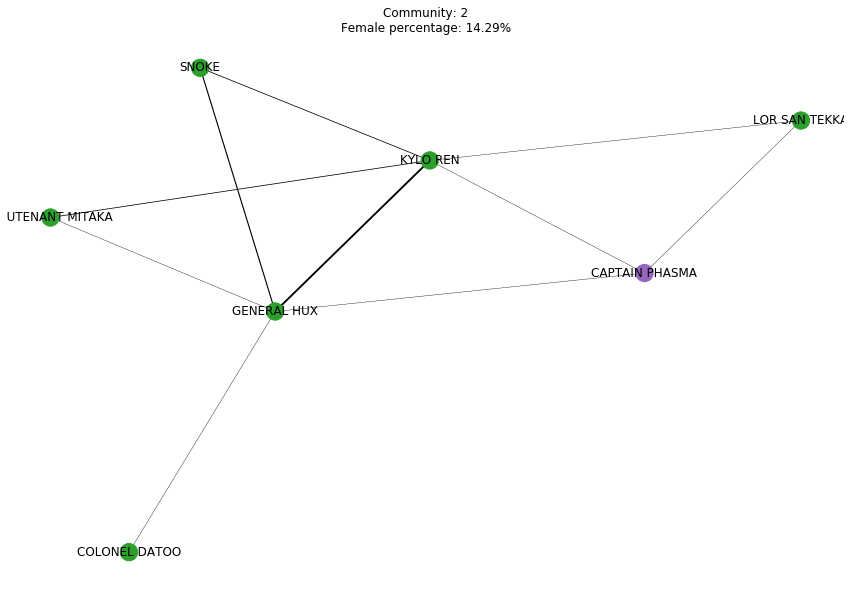

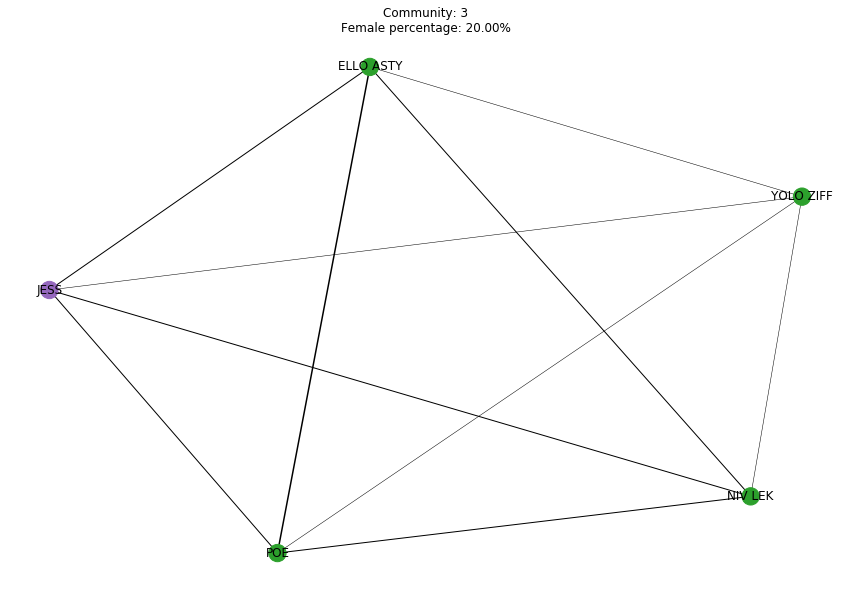

In [18]:
EPISODE = 'episode-7'
EPISODES.append(EPISODE)
interaction_network = INTERACTION_NETWORKS[EPISODE]
community_percentages = list()
for comm, no in calculate_communities(interaction_network):
    female_percentage = plot_community(comm, no)
    community_percentages.append(female_percentage)
print(f'Average Female Percentage: {np.mean(community_percentages):.2f}%')
FEMALE_PERCENTAGE[EPISODE] = community_percentages

### 3.1.8 Discussion

In [19]:
TRIOLOGIES = {
    '1. Triology': ['episode-4', 'episode-5', 'episode-6'],
    '2. Triology': ['episode-1', 'episode-2', 'episode-3'],
    '3. Triology': ['episode-7'],
}

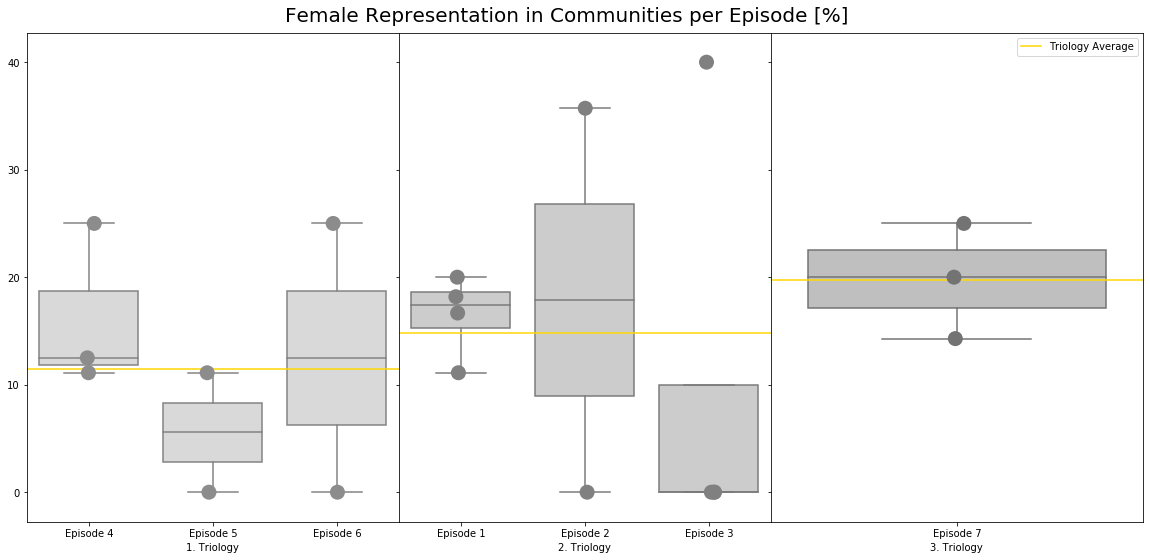

In [20]:
TRIOLOGY_AVERAGE = dict()
for triology, episodes in TRIOLOGIES.items():
    TRIOLOGY_AVERAGE[triology] = np.mean([np.mean(percentages) for episode, percentages in FEMALE_PERCENTAGE.items() if episode in episodes])

colors_light = ['#d9d9d9', '#cccccc', '#bfbfbf']
colors = ['#8c8c8c', '#808080', '#737373']

fig, axes = plt.subplots(figsize=(20,9), ncols=len(TRIOLOGIES.keys()), sharey=True)
fig.subplots_adjust(wspace=0)

for idx, (ax, name) in enumerate(zip(axes, TRIOLOGIES.keys())):
    records = list()
    for episode in TRIOLOGIES[name]:
        for percentage in FEMALE_PERCENTAGE[episode]:
            records.append([name, episode, percentage])
    df = pd.DataFrame(records, columns=['triology', 'episode', 'percentages'])
    boxes = sns.boxplot(y='percentages', x='episode', color=colors_light[idx], data=df, ax=ax)
    strips = sns.stripplot(y='percentages', x='episode', color=colors[idx], data=df, jitter=0.05, ax=ax, size=15)
    ax.set(xticklabels=list(map(lambda ep: ep.replace('-', ' ').title(), TRIOLOGIES[name])), xlabel=name, ylabel='')
    ax.margins(0.05) # Optional
    ax.axhline(TRIOLOGY_AVERAGE[name], color='gold')
plt.plot([], c='gold', label='Triology Average')
fig.suptitle('Female Representation in Communities per Episode [%]', fontsize=20, y=0.92)
plt.legend()
plt.savefig(os.path.join('plots', 'female_representation_in_communities_per_episode.png'))

In [21]:
TRIOLOGY_PERCENTAGES = dict()
for triology in TRIOLOGIES.keys():
    percentages = list()
    for episode in TRIOLOGIES[triology]:
        percentages.extend(FEMALE_PERCENTAGE[episode])
    TRIOLOGY_PERCENTAGES[triology] = percentages

records_trio = list()
for triology, percentages in TRIOLOGY_PERCENTAGES.items():
    for percentage in percentages:
        records_trio.append([triology, percentage])

records_eps = list()
for episode, percentages in FEMALE_PERCENTAGE.items():
    for percentage in percentages:
        records_eps.append([episode, percentage])

In [22]:
df_trio = pd.DataFrame(records_trio, columns=['Triology', 'Percentage'])
df_eps = pd.DataFrame(records_eps, columns=['Episode', 'Percentage'])

Let's perform a one-way ANOVA.

In [23]:
lm_trio = ols('Percentage ~ C(Triology)', data=df_trio).fit()
table_trio = sm.stats.anova_lm(lm_trio)
lm_eps = ols('Percentage ~ C(Episode)', data=df_eps).fit()
table_eps = sm.stats.anova_lm(lm_eps)
print('Triology ANOVA')
print(table_trio)
print('\nEpisode ANOVA')
print(table_eps)

Triology ANOVA
               df       sum_sq     mean_sq         F    PR(>F)
C(Triology)   2.0   123.450301   61.725150  0.390751  0.682471
Residual     17.0  2685.413135  157.965479       NaN       NaN

Episode ANOVA
              df       sum_sq     mean_sq         F    PR(>F)
C(Episode)   6.0   378.224191   63.037365  0.337148  0.905106
Residual    13.0  2430.639245  186.972250       NaN       NaN


There is no particular trend visible in terms of female percentages in communities per episodes. 
There is an indiciation of a rising trend considering the average per triology but this might not be significant. 
Furthermore, we only have data for episode 7 of the 3. triology, which might indicate a false average, 
however, since the 3. triology stars a female main actor, it might very well be true.

We also conducte a One-Way ANOVA with the percentages per community in a triology with

$H_0 =$ there is no significant change in female representation in the communities amongst triologies, and

$H_A =$ there is a significant change in female representation in the communities amongst triologies

as well as a One-Way ANOVA with the percentages per community in an episode with

$H_0 =$ there is no significant change in female representation in the communities amongst episodes, and

$H_A =$ there is a significant change in female representation in the communities amongst episodes.


In either ANOVA tests the null hypothesis prevailed and the alternative hypothesis got rejected (p-value of 0.68 and 0.90). 

This means, there is no significant change in female representation in the communities to be observed.


## 3.2 Change in gender ratio during the episodes​

For this comparison, we will not consider the individual communities.

{'episode-4': 16.203703703703706, 'episode-5': 5.555555555555555, 'episode-6': 12.5, 'episode-1': 16.48989898989899, 'episode-2': 17.857142857142858, 'episode-3': 10.0, 'episode-7': 19.761904761904763}


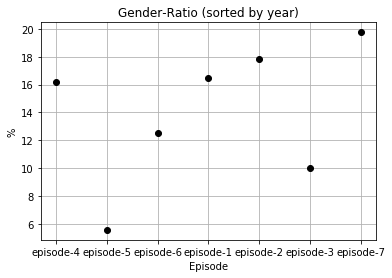

In [24]:
genderratio = {k:sum(x)/len(x) for k,x in FEMALE_PERCENTAGE.items()}
print(genderratio)

x = list(genderratio.keys())
y = list(genderratio.values())

plt.plot(x, y, 'o', color='black')
plt.grid()
plt.title("Gender-Ratio (sorted by year)")
plt.xlabel("Episode")
plt.ylabel("%");

## 3.3 Number of cross-gender interactions ​

For this analysis, we will analyse **interactions**.

1. number of interactions per episode (absolute)
2. number of cross-gender interactions per episode (absolute)
3. proportion of cross-gender interactions per episode (percent)
4. proportion of cross-gender mentions in the episodes (absolute)

### 3.3.1. Number of Interactions per Episode (absolute)

In [25]:
data_allep = DATA['starwars-full-interactions-allCharacters']

anz_interactions_Nodes = 0
anz_interactions_Links = 0

for item in data_allep['nodes']:
    anz_interactions_Nodes += item["value"]

for item in data_allep['links']:
    anz_interactions_Links+= item["value"]

print(anz_interactions_Nodes, "Documented Character (Value in Node-Dict)")
print(anz_interactions_Links, "Documented Interactions (Value in Link-Dict)")

2473 Documented Character (Value in Node-Dict)
2093 Documented Interactions (Value in Link-Dict)


### 3.3.2 Number of cross-gender interactions per episode (absolute)

Viewing dataset "Full interaction (all episodes)".

In [26]:
#---Target-Dataframe erstellen

target_index = 0
index_mapping = {"Target-Figur":[], "target_index" : []}

for character in data_allep["nodes"]:
    index_mapping["Target-Figur"].append(character["name"])
    index_mapping["target_index"].append(target_index)
    target_index += 1

df1 = pd.DataFrame.from_dict(index_mapping)



#----Attribute Namen & Gender hinzufügen

data_gender = DATA['gender_mapping']

index_gender_mapping = {"Target-Figur":[], "target-gender":[]}

for gender in data_gender["nodes"]:
    index_gender_mapping["Target-Figur"].append(gender["name"])
    index_gender_mapping["target-gender"].append(gender["gender"])

df2 = pd.DataFrame.from_dict(index_gender_mapping)


df_target_merged = pd.merge(df1,df2,on='Target-Figur',how='left')
print(df_target_merged)



      Target-Figur  target_index target-gender
0            R2-D2             0          Male
1        CHEWBACCA             1          Male
2             BB-8             2          Male
3          QUI-GON             3          Male
4      NUTE GUNRAY             4          Male
..             ...           ...           ...
107      YOLO ZIFF           107          Male
108  COLONEL DATOO           108          Male
109      ELLO ASTY           109          Male
110           JESS           110        Female
111        NIV LEK           111          Male

[112 rows x 3 columns]


In [27]:
##---Source-Dataframe erstellen
df_source_merged = pd.merge(df1,df2,on='Target-Figur',how='left')
df_source_merged = df_source_merged.rename(columns={"Target-Figur": "Source-Figur", "target_index": "source_index", "target-gender":"source-gender"})
print(df_source_merged)


      Source-Figur  source_index source-gender
0            R2-D2             0          Male
1        CHEWBACCA             1          Male
2             BB-8             2          Male
3          QUI-GON             3          Male
4      NUTE GUNRAY             4          Male
..             ...           ...           ...
107      YOLO ZIFF           107          Male
108  COLONEL DATOO           108          Male
109      ELLO ASTY           109          Male
110           JESS           110        Female
111        NIV LEK           111          Male

[112 rows x 3 columns]


In [28]:
#----Link Value Dataframe

Value_Mapping_df = pd.DataFrame.from_dict(data_allep["links"])
Value_Mapping_df1 = Value_Mapping_df.rename(columns={'target': 'target_index', 'source': 'source_index'})
print(Value_Mapping_df1)


     source_index  target_index  value
0               1             0     17
1               2             0      2
2               2             1      8
3               7             0     28
4              17             0     24
..            ...           ...    ...
445           109           110      2
446            94           107      1
447           109           107      1
448            70            99      1
449            67            99      1

[450 rows x 3 columns]


In [29]:
#---Teildatensets mergen

result_merge1 = pd.merge(df_target_merged, Value_Mapping_df1, on='target_index')
result_merge2 = pd.merge(df_source_merged, result_merge1, on='source_index')
print(result_merge2)

print(len(data_allep["links"])) #Vergleich mit Link-Files in .json

    Source-Figur  source_index source-gender Target-Figur  target_index  \
0          R2-D2             0          Male        WATTO            19   
1          R2-D2             0          Male         YODA            34   
2      CHEWBACCA             1          Male        R2-D2             0   
3      CHEWBACCA             1          Male      OBI-WAN             7   
4      CHEWBACCA             1          Male        JABBA            29   
..           ...           ...           ...          ...           ...   
445         JESS           110        Female         SNAP           105   
446         JESS           110        Female    YOLO ZIFF           107   
447         JESS           110        Female      NIV LEK           111   
448      NIV LEK           111          Male          POE            94   
449      NIV LEK           111          Male    YOLO ZIFF           107   

    target-gender  value  
0            Male      3  
1            Male      5  
2            Male 

In [30]:
#---Zeilen filtern, Cross-Gender-Interaction dokumentieren

result_filtered = result_merge2.loc[((result_merge2["source-gender"]== "Male") & (result_merge2["target-gender"]== "Female")) | ((result_merge2["source-gender"]== "Female") & (result_merge2["target-gender"]== "Male"))]
print(result_filtered)

sum(result_filtered["value"])

    Source-Figur  source_index source-gender Target-Figur  target_index  \
7      CHEWBACCA             1          Male         LEIA            70   
14     CHEWBACCA             1          Male          REY            99   
15     CHEWBACCA             1          Male          MAZ           104   
19          BB-8             2          Male         LEIA            70   
25          BB-8             2          Male          REY            99   
..           ...           ...           ...          ...           ...   
442    ELLO ASTY           109          Male         JESS           110   
444         JESS           110        Female          POE            94   
445         JESS           110        Female         SNAP           105   
446         JESS           110        Female    YOLO ZIFF           107   
447         JESS           110        Female      NIV LEK           111   

    target-gender  value  
7          Female     48  
14         Female     13  
15         Female 

612

A total of 2473 interactions took place.
612 interactions were *cross-gender interactions*.

### 3.3.3 Proportion of cross-gender interactions per episode (percent)

In [31]:
gender_lookup_dict = dict()
for element in DATA['gender_mapping']['nodes']:
    gender_lookup_dict[element['name']] = element['gender']

def get_gender_mapped_df_for_edges(episode, network_type='mentions'):
    NETWORKS = MENTION_NETWORKS if network_type == 'mentions' else INTERACTION_NETWORKS
    if network_type == 'mentions' and not episode.endswith('-mentions'):
        episode = f'{episode}-mentions'
    records = list()
    for node_from, node_to, data in list(NETWORKS[episode].edges(data=True)):
        value = data['value']
        gender_from = gender_lookup_dict[node_from]
        gender_to = gender_lookup_dict[node_to]
        records.append([node_from, gender_from, node_to, gender_to, value])
    return pd.DataFrame(records, columns=['node_from', 'gender_from', 'node_to', 'gender_to', 'value'])

def get_stats(df):
    df_xg_mention = df[((df['gender_from'] == 'Male') & (df['gender_to'] == 'Female') | (df['gender_from'] == 'Female') & (df['gender_to'] == 'Male'))]
    df_sg_mention = df[~df.isin(df_xg_mention)].dropna()
    df_sg_mention_female = df_sg_mention[df_sg_mention['gender_from'] == 'Female']
    return sum(df['value']), sum(df_xg_mention['value']), sum(df_sg_mention['value']), sum(df_sg_mention_female['value'])

def get_eval(stats):
    for episode, numbers in stats.items():
        print(f'{episode}:')
        print(f'\tAvailable: {numbers[0]:.0f}')
        print(f'\tCross-gender: {numbers[1]:.0f}')
        print(f'\tSame-gender: {numbers[2]:.0f}')
        print(f'\tSame-gender of women: {numbers[3]:.0f}')

    print('-'*20)
    print('Totals:')
    print(f'\tAvailable: {sum([stat[0] for stat in stats.values()]):.0f}')
    print(f'\tCross-gender: {sum([stat[1] for stat in stats.values()]):.0f}')
    print(f'\tSame-gender: {sum([stat[2] for stat in stats.values()]):.0f}')
    print(f'\tSame-gender of women: {sum([stat[3] for stat in stats.values()]):.0f}')


In [32]:
stats_int = dict()
for episode in INTERACTION_NETWORKS:
    stats_int[episode.replace('-interactions', '')] = get_stats(get_gender_mapped_df_for_edges(episode, network_type='interaction'))

get_eval(stats_int)

episode-1:
	Available: 437
	Cross-gender: 115
	Same-gender: 322
	Same-gender of women: 6
episode-3:
	Available: 219
	Cross-gender: 43
	Same-gender: 176
	Same-gender of women: 2
episode-2:
	Available: 212
	Cross-gender: 66
	Same-gender: 146
	Same-gender of women: 5
episode-6:
	Available: 269
	Cross-gender: 78
	Same-gender: 191
	Same-gender of women: 1
episode-7:
	Available: 347
	Cross-gender: 139
	Same-gender: 208
	Same-gender of women: 3
episode-5:
	Available: 284
	Cross-gender: 98
	Same-gender: 186
	Same-gender of women: 0
episode-4:
	Available: 286
	Cross-gender: 68
	Same-gender: 218
	Same-gender of women: 1
--------------------
Totals:
	Available: 2054
	Cross-gender: 607
	Same-gender: 1447
	Same-gender of women: 18


### 3.3.4 Proportion of cross-gender mentions in episodes (Absolute)

Collect data

In [33]:
stats_mention = dict()
for episode in MENTION_NETWORKS:
    stats_mention[episode.replace('-mentions', '')] = get_stats(get_gender_mapped_df_for_edges(episode))

Evaluate on absolute stats

In [34]:
get_eval(stats_mention)

episode-1:
	Available: 1282
	Cross-gender: 380
	Same-gender: 902
	Same-gender of women: 23
episode-4:
	Available: 745
	Cross-gender: 180
	Same-gender: 565
	Same-gender of women: 3
episode-6:
	Available: 724
	Cross-gender: 153
	Same-gender: 571
	Same-gender of women: 1
episode-3:
	Available: 744
	Cross-gender: 127
	Same-gender: 617
	Same-gender of women: 3
episode-2:
	Available: 602
	Cross-gender: 194
	Same-gender: 408
	Same-gender of women: 13
episode-7:
	Available: 747
	Cross-gender: 308
	Same-gender: 439
	Same-gender of women: 14
episode-5:
	Available: 690
	Cross-gender: 219
	Same-gender: 471
	Same-gender of women: 0
--------------------
Totals:
	Available: 5534
	Cross-gender: 1561
	Same-gender: 3973
	Same-gender of women: 57


Discussion:

Women hardly ever talk about other women (roughly 1% of all mentions are from women about women). 
The worst episode is episode 5, where no mentions of other women by women occur.
The best episode is episode 1 with a total of 23 mentions. 
There is no trend visible as to whether the franchise is improving in terms of "women only talk about men (or get talked about by men) on screen".

### 3.3.5 Female Interactions

In [35]:
genders_df = pd.DataFrame(DATA['gender_mapping']['nodes'], columns=['name', 'gender'])
character_gender_count = genders_df.groupby('gender').count()['name'].to_dict()

In [36]:
cross_gender_interactions = list()
for episode in INTERACTION_NETWORKS:
    df = get_gender_mapped_df_for_edges(episode, network_type='interaction')
    df_female = df[(df['gender_from'] == 'Female') | (df['gender_to'] == 'Female')]
    df_male_sg = df[~df.isin(df_female)].dropna()
    df_female_sg = df_female[(df['gender_from'] == df['gender_to'])]
    df_male = df[~df.isin(df_female_sg)].dropna()
    cross_gender_interactions.append(((sum(df_female.value)-sum(df_female_sg.value))/sum(df.value))*100)
    out_string = [f'Episode: {episode}']
    out_string.append(f'Total Interactions: {sum(df.value):.0f}')
    out_string.append(f'Female Interactions: {sum(df_female.value):.0f}')
    out_string.append(f'Female Same Gender Interactions: {sum(df_female_sg.value):.0f} -> {(sum(df_female_sg.value)/sum(df_female.value))*100:.2f}%')
    out_string.append(f'Male Interactions: {sum(df_male.value):.0f}')
    out_string.append(f'Male Same Gender Interactions: {sum(df_male_sg.value):.0f} -> {(sum(df_male_sg.value)/sum(df_male.value))*100:.2f}%')
    print('\n\t'.join(out_string))

Episode: episode-1
	Total Interactions: 437
	Female Interactions: 121
	Female Same Gender Interactions: 6 -> 4.96%
	Male Interactions: 431
	Male Same Gender Interactions: 316 -> 73.32%
Episode: episode-3
	Total Interactions: 219
	Female Interactions: 45
	Female Same Gender Interactions: 2 -> 4.44%
	Male Interactions: 217
	Male Same Gender Interactions: 174 -> 80.18%
Episode: episode-2
	Total Interactions: 212
	Female Interactions: 71
	Female Same Gender Interactions: 5 -> 7.04%
	Male Interactions: 207
	Male Same Gender Interactions: 141 -> 68.12%
Episode: episode-6
	Total Interactions: 269
	Female Interactions: 79
	Female Same Gender Interactions: 1 -> 1.27%
	Male Interactions: 268
	Male Same Gender Interactions: 190 -> 70.90%
Episode: episode-7
	Total Interactions: 347
	Female Interactions: 142
	Female Same Gender Interactions: 3 -> 2.11%
	Male Interactions: 344
	Male Same Gender Interactions: 205 -> 59.59%
Episode: episode-5
	Total Interactions: 284
	Female Interactions: 98
	Female S

This shows again, if women are involved in an interaction, they hardly ever interact with the same gender.
Is there a change in cross gender interaction amongst episodes? Let's do an ANOVA test to verify.

The cross gender interactions which we will be using in the wilcoxon test are adjusted for the overall amount of interactions per episode.
For the scipy implementation of wilcoxon, we will need to 0 center the data in order for it to be usable, since we cannot specify a mu as we do in R.

In [37]:
cross_gender_interactions = [value - statistics.mean(cross_gender_interactions) for value in cross_gender_interactions]

In [38]:
w, p = wilcoxon(cross_gender_interactions, alternative='two-sided', mode='exact') # mode exact since we do have fewer than 20 samples
print(p)

0.9375


The p-Value is not significant, hence the H0 will not be rejected. This means, we do not have any deviation from the average thus, the change in interactions is not significant.